# GSE176078 Model Generation and Validation

## Table of Contents
1. [Imports](#imports)
2. [Path for Assets](#path-for-assets)
3. [Machine Learning Model Generation](#machine-learning-model-generation)
4. [Model Validation](#model-validation)

## Imports

In [ ]:
# Necessary imports for the notebook. Please ensure these libraries are installed in your Python environment, if not then please install them using the requirements.txt file.
import os
os.environ["SCIPY_ARRAY_API"] = "1"
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

___

## Path for Assets

In [ ]:
# This is the relative path of the assets directory, if the assets are in another location please change the path accordingly.
assets = "../assets/"

___

# Machine Learning Model Generation

In [ ]:
# Reading the GSE176078 obs file generated by the GSE176078.ipynb notebook.
df = pd.read_csv(f"{assets}GSE176078_obs.csv")

✅ SMOTE applied: (153134, 9)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


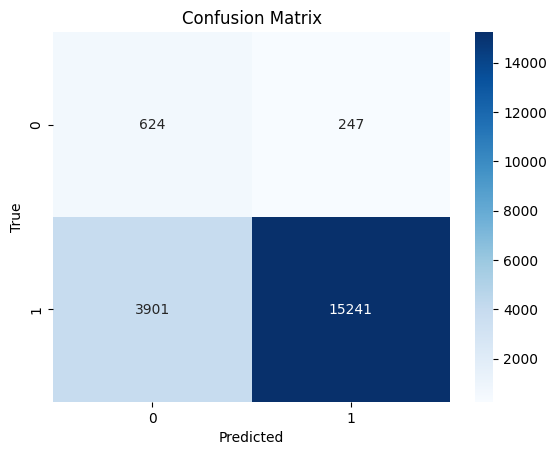

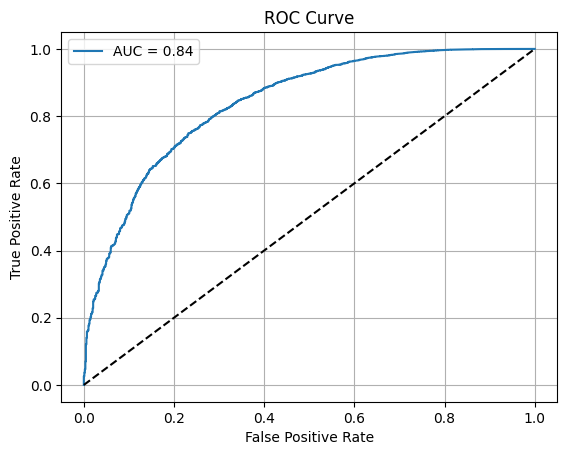

📊 Classification Report:

              precision    recall  f1-score   support

      Normal       0.14      0.72      0.23       871
       Tumor       0.98      0.80      0.88     19142

    accuracy                           0.79     20013
   macro avg       0.56      0.76      0.56     20013
weighted avg       0.95      0.79      0.85     20013



In [ ]:


# Defining top features.
top_features = [
    "apoptosis_score", "oxphos_score",
    "pct_counts_ribo", "nCount_RNA", "cnv_score",
    "proto_oncogenescore", "S_score", "G2M_score","percent.mito"
]

# Droping NA and prepare X, y.
df_clean = df.dropna(subset=top_features + ["cnv_reference"])
X = df_clean[top_features]
y = df_clean["cnv_reference"].map({"normal": 0, "tumor": 1})

# Encoding target.
le = LabelEncoder()
y_encoded = le.fit_transform(y)

#Train/test split before SMOTE.
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# SMOTE for balanced training.
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print("✅ SMOTE applied:", X_train_sm.shape)

# Training XGBoost CLassifier.
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=3,
    n_estimators=50,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    random_state=42
)
xgb.fit(X_train_sm, y_train_sm)

# Evaluation
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Classification Report
print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Normal", "Tumor"]))



🔧 Classification Report at threshold = 0.65

              precision    recall  f1-score   support

      Normal       0.10      0.84      0.18       871
       Tumor       0.99      0.66      0.79     19142

    accuracy                           0.67     20013
   macro avg       0.54      0.75      0.48     20013
weighted avg       0.95      0.67      0.76     20013



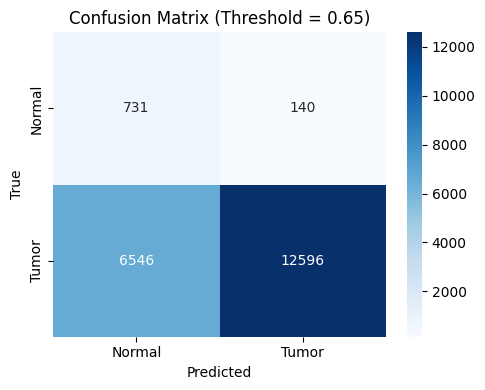

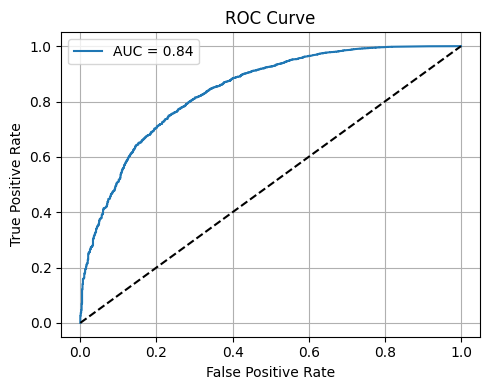

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Assume you already have:
# y_test = true labels
# y_prob = predicted probabilities for the tumor class (i.e., model.predict_proba(X_test)[:, 1])
# le = fitted LabelEncoder() for decoding class labels (optional, if used before)

# Step 1: Set a new threshold
threshold = 0.65  # try values between 0.5 and 0.75

# Step 2: Predict using new threshold
y_pred_adj = (y_prob > threshold).astype(int)

# Step 3: Classification Report
print(f"🔧 Classification Report at threshold = {threshold}\n")
print(classification_report(y_test, y_pred_adj, target_names=["Normal", "Tumor"]))

# Step 4: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_adj)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Tumor"], yticklabels=["Normal", "Tumor"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Threshold = {threshold})")
plt.tight_layout()
plt.show()

# Step 5: Plot ROC Curve for reference
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

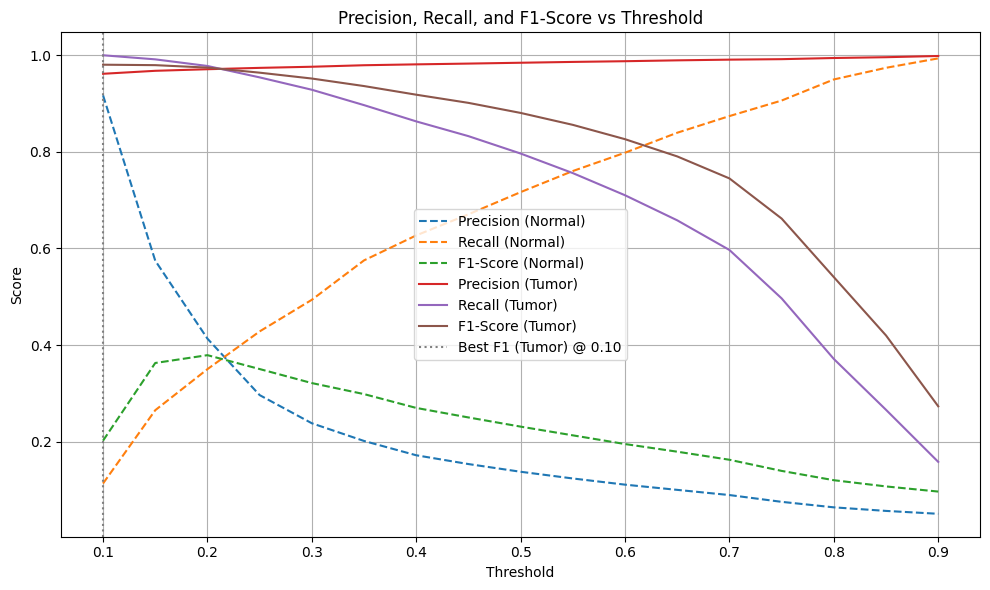

🏆 Best Tumor F1-Score = 0.98 at Threshold = 0.10


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

# Predict probabilities
y_scores = xgb.predict_proba(X_test)[:, 1]

# Define thresholds to evaluate
thresholds = np.arange(0.1, 0.95, 0.05)

# Containers
precision_norm, recall_norm, f1_norm = [], [], []
precision_tumor, recall_tumor, f1_tumor = [], [], []

for t in thresholds:
    y_pred_thresh = (y_scores > t).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred_thresh, labels=[0, 1], zero_division=0)

    precision_norm.append(p[0])
    recall_norm.append(r[0])
    f1_norm.append(f1[0])

    precision_tumor.append(p[1])
    recall_tumor.append(r[1])
    f1_tumor.append(f1[1])

# Find best threshold for tumor F1
best_idx = np.argmax(f1_tumor)
best_thresh = thresholds[best_idx]
best_f1 = f1_tumor[best_idx]

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(thresholds, precision_norm, label="Precision (Normal)", linestyle='--')
plt.plot(thresholds, recall_norm, label="Recall (Normal)", linestyle='--')
plt.plot(thresholds, f1_norm, label="F1-Score (Normal)", linestyle='--')

plt.plot(thresholds, precision_tumor, label="Precision (Tumor)", linestyle='-')
plt.plot(thresholds, recall_tumor, label="Recall (Tumor)", linestyle='-')
plt.plot(thresholds, f1_tumor, label="F1-Score (Tumor)", linestyle='-')

# Add vertical line for best F1
plt.axvline(x=best_thresh, color='gray', linestyle=':', label=f"Best F1 (Tumor) @ {best_thresh:.2f}")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score vs Threshold")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print best threshold
print(f"🏆 Best Tumor F1-Score = {best_f1:.2f} at Threshold = {best_thresh:.2f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:47:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


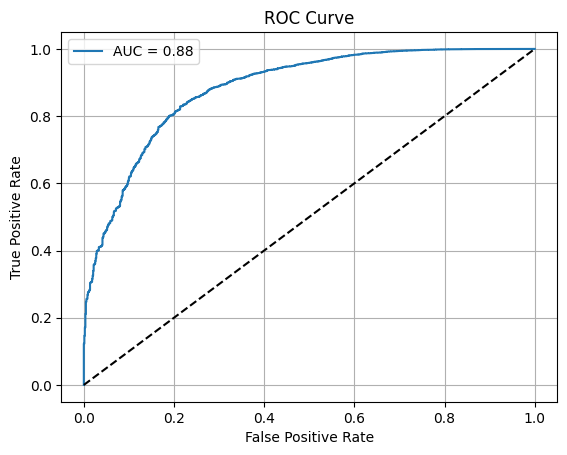

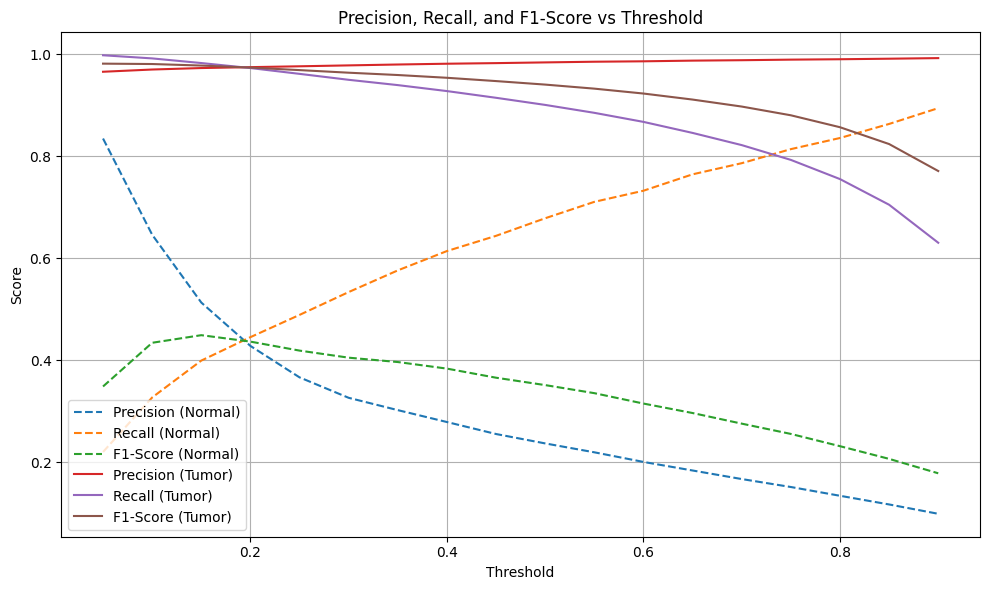

📌 Best Tumor F1: 0.98 at Threshold = 0.05


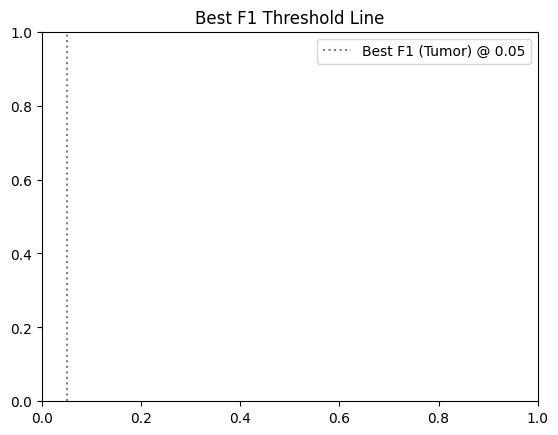


Classification Report at threshold = 0.05
              precision    recall  f1-score   support

      Normal       0.83      0.22      0.35       871
       Tumor       0.97      1.00      0.98     19142

    accuracy                           0.96     20013
   macro avg       0.90      0.61      0.67     20013
weighted avg       0.96      0.96      0.95     20013



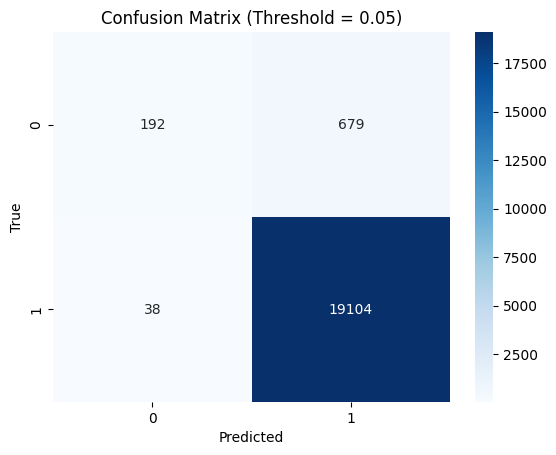

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix,
    classification_report, precision_score,
    recall_score, f1_score
)
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns


# Define features and target
features = [
    "apoptosis_score", "oxphos_score",
    "pct_counts_ribo", "nCount_RNA", "cnv_score",
    "proto_oncogenescore", "S_score", "G2M_score","percent.mito"
]

X = df[features]
y = df['cnv_reference'].map({'normal': 0, 'tumor': 1})  # binary target

# Encode target if needed
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_sm, y_train_sm)

# Predict probabilities
y_prob = xgb.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Threshold analysis
thresholds = np.arange(0.05, 0.95, 0.05)
precision_normal, recall_normal, f1_normal = [], [], []
precision_tumor, recall_tumor, f1_tumor = [], [], []

for t in thresholds:
    y_pred_thresh = (y_prob >= t).astype(int)
    precision_normal.append(precision_score(y_test, y_pred_thresh, pos_label=0))
    recall_normal.append(recall_score(y_test, y_pred_thresh, pos_label=0))
    f1_normal.append(f1_score(y_test, y_pred_thresh, pos_label=0))
    precision_tumor.append(precision_score(y_test, y_pred_thresh, pos_label=1))
    recall_tumor.append(recall_score(y_test, y_pred_thresh, pos_label=1))
    f1_tumor.append(f1_score(y_test, y_pred_thresh, pos_label=1))

# Plot precision/recall/F1 vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_normal, label="Precision (Normal)", linestyle='--')
plt.plot(thresholds, recall_normal, label="Recall (Normal)", linestyle='--')
plt.plot(thresholds, f1_normal, label="F1-Score (Normal)", linestyle='--')

plt.plot(thresholds, precision_tumor, label="Precision (Tumor)", linestyle='-')
plt.plot(thresholds, recall_tumor, label="Recall (Tumor)", linestyle='-')
plt.plot(thresholds, f1_tumor, label="F1-Score (Tumor)", linestyle='-')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score vs Threshold")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

# Best F1 for Tumor
best_idx = np.argmax(f1_tumor)
best_thresh = thresholds[best_idx]
best_f1 = f1_tumor[best_idx]
print(f"📌 Best Tumor F1: {best_f1:.2f} at Threshold = {best_thresh:.2f}")

# Optional: Plot best threshold line
plt.figure()
plt.axvline(x=best_thresh, color='gray', linestyle=':', label=f"Best F1 (Tumor) @ {best_thresh:.2f}")
plt.title("Best F1 Threshold Line")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.legend()
plt.show()

# Classification report at best threshold
y_pred_final = (y_prob >= best_thresh).astype(int)
print("\nClassification Report at threshold =", best_thresh)
print(classification_report(y_test, y_pred_final, target_names=["Normal", "Tumor"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Threshold = {best_thresh:.2f})')
plt.show()

100%|===================| 152978/153134 [13:09<00:00]       

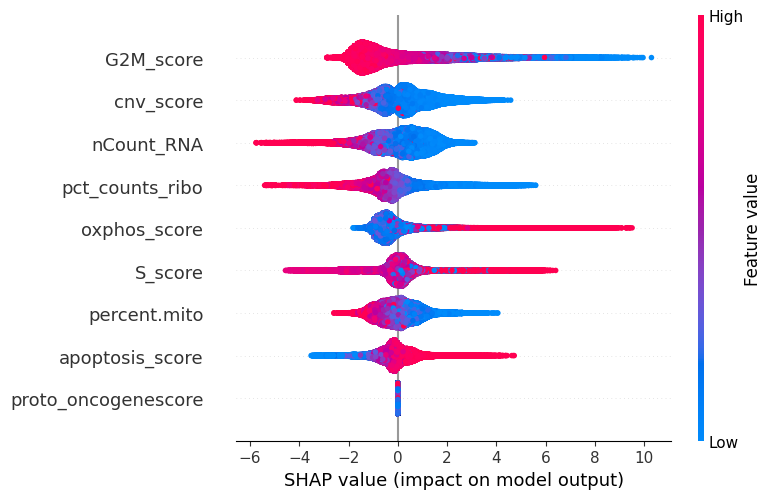

In [7]:
import shap

# Step 1: Initialize SHAP explainer
explainer = shap.Explainer(xgb, X_train_sm)

# Step 2: Compute SHAP values
shap_values = explainer(X_train_sm)

# Step 3: SHAP summary plot
shap.summary_plot(shap_values, features=X_train_sm, feature_names=features, show=True)




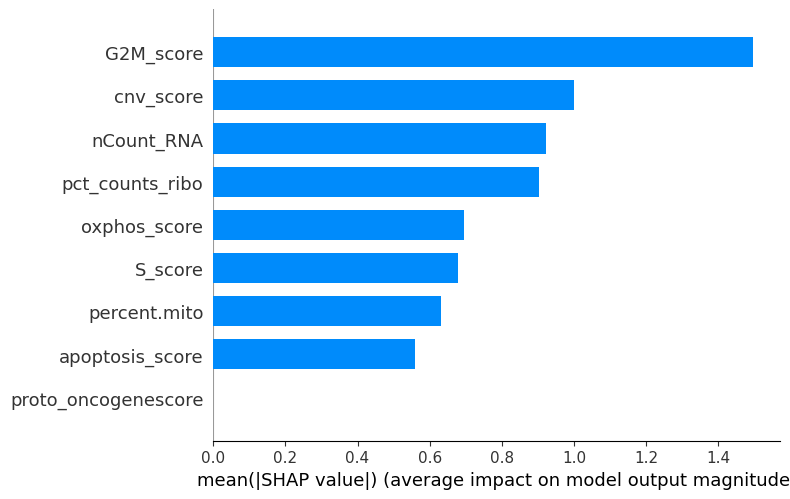

In [9]:
shap.summary_plot(shap_values, features=X_train_sm, feature_names=features, plot_type="bar", show=True)

In [10]:
## Saving the XGBoost model trained on GSE176078 dataset with percent.mito...new model with adata_obs_full regenarated as a dedictated notebook - GSE176078_refined_17July.ipynb
import joblib

# Save model
joblib.dump(xgb, "/content/drive/MyDrive/Capstone (Haider, Rajeev)/ghost-cell-busters/xgb_model_mito_17July.pkl")

print("✅ Model saved as xgb_model_mito_17July.pkl")

✅ Model saved as xgb_model_mito_17July.pkl


In [ ]:
## Saving the XGBoost model trained on GSE176078 dataset with percent.mito
##import joblib

# Save model
##joblib.dump(xgb, "/content/drive/MyDrive/Capstone (Haider, Rajeev)/ghost-cell-busters/xgb_model_mito_14July.pkl")

##print("✅ Model saved as xgb_model_mito_14July.pkl")

✅ Model saved as xgb_model_mito_14July.pkl
